# **Import Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import os
import cv2
import keras
import tensorflow as tf
from PIL import Image
from tensorflow.keras.utils import load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.regularizers import l2

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,recall_score,precision_score
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input
from keras import optimizers
from tqdm.notebook import tqdm 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

# **Load the images and extract the meta data**

In [2]:
# Load the images.
path = "/kaggle/input/utkface-new/UTKFace"
files = os.listdir(path)

print("Total images:",len(files))

Total images: 23708


In [3]:
age_labels = []
gender_labels = []
image_paths = []

# Shuffle the image before loading it.
image_filenames = os.listdir(path)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  # Extract the Meta Data from the images. 
  image_path = os.path.join(path, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

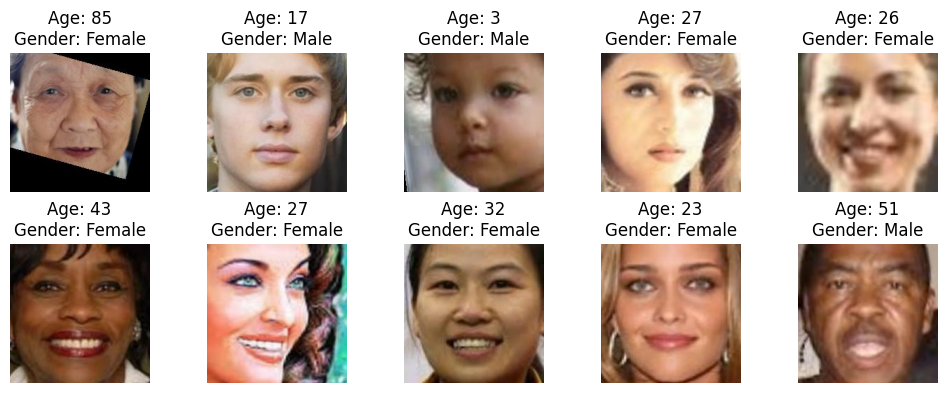

In [4]:
# Mapping function to convert 0 to 'Male' and 1 to 'Female'
def map_gender_label(gender):
    return 'Male' if gender == 0 else 'Female'

# Create a 2x5 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through the first 10 images and display them
for i in range(10):
    image_path = image_paths[i]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Map gender label from 0/1 to 'Male'/'Female'
    gender_display = map_gender_label(gender_labels[i])
    
    axes[i].imshow(image)
    axes[i].axis('off')  # Remove axis ticks
    axes[i].set_title(f"Age: {age_labels[i]}\nGender: {gender_display}")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [5]:
images = pd.Series(list(image_paths), name="Image_Paths")
ages = pd.Series(list(age_labels), name="Ages")
genders = pd.Series(list(gender_labels), name="Genders")

df = pd.concat([images, ages, genders], axis=1)
df.head()

,Image_Paths,Ages,Genders
0,/kaggle/input/utkface-new/UTKFace/85_1_2_20170...,85,1
1,/kaggle/input/utkface-new/UTKFace/17_0_0_20170...,17,0
2,/kaggle/input/utkface-new/UTKFace/3_0_4_201612...,3,0
3,/kaggle/input/utkface-new/UTKFace/27_1_3_20170...,27,1
4,/kaggle/input/utkface-new/UTKFace/26_1_0_20170...,26,1


In [6]:
df.shape

(23708, 3)

In [7]:
# Save the dataset
#df.to_csv("images_df.csv")

In [8]:
# Count the occurrences of each gender
genders_count = df["Genders"].value_counts()
genders_count

Genders
0    12391
1    11317
Name: count, dtype: int64

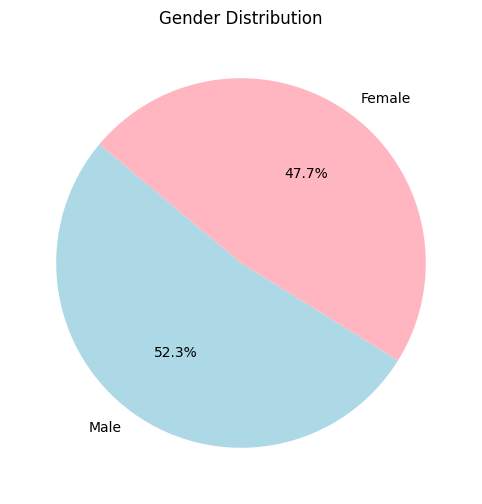

In [9]:
labels = ['Male', 'Female']
sizes = genders_count.values
colors = ['lightblue', 'lightpink']

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution')
plt.show()

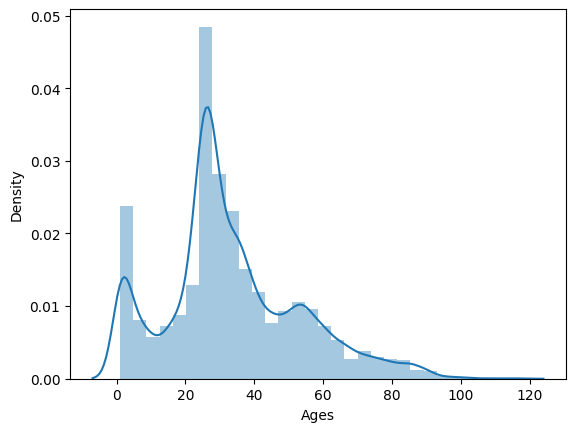

In [10]:
sns.distplot(df['Ages'],kde=True, bins=30);

# Models

In [11]:
# Read the images, reshape it to (128,128), 
# finnaly reshape the features as (Num of Sample, height, width, Num of channels).
def image_preprocessing(images):
    features = list()
    
    for image in tqdm(images):
        img = cv2.imread(image,0)
        # Convert the OpenCV image to a PIL image
        img = Image.fromarray(img)
        img = img.resize((128,128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [12]:
X = image_preprocessing(df["Image_Paths"])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [13]:
X.shape

(23708, 128, 128, 1)

In [14]:
# Normalizatio
X = X / 255.0

In [15]:
y_gender = np.array(df['Genders'])
y_age = np.array(df['Ages'])

# **Modeling**

## **First Model**

In [16]:
input_shape = (128,128,1)
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(128, activation='relu')(flatten)
dense_2 = Dense(128, activation='relu')(flatten)

dropout_1 = Dropout(0.5)(dense_1)
dropout_2 = Dropout(0.5)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out', kernel_regularizer=l2(0.001))(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out', kernel_regularizer=l2(0.001))(dropout_2)

model_all = Model(inputs=[inputs], outputs=[output_1, output_2])

model_all.compile(
    loss={'gender_out': 'binary_crossentropy', 'age_out': 'mae'}, 
    optimizer='adam', 
    metrics={'gender_out': 'accuracy', 'age_out': 'mae'}
)

In [17]:
model_all.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 9216)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  1,179,776 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │  1,179,776 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        129 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,747,650 (10.48 MB)

 Trainable params: 2,747,650 (10.48 MB)

 Non-trainable params: 0 (0.00 B)

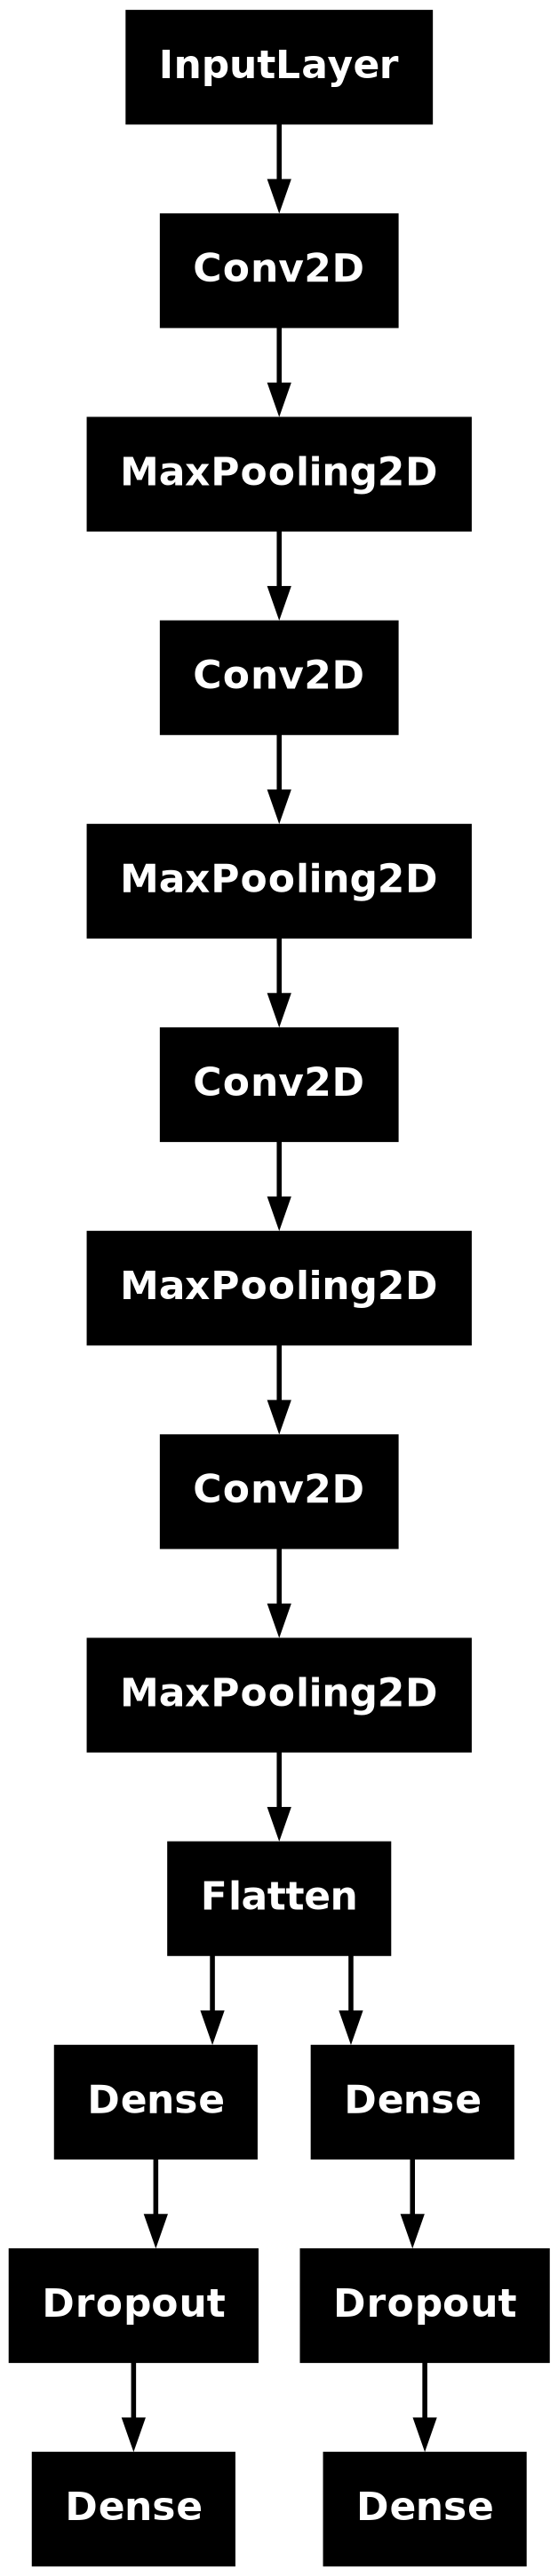

In [18]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model_all)

In [19]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [20]:
history = model_all.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=50, validation_split=0.2, 
                    callbacks=[early_stopping])

Epoch 1/50


I0000 00:00:1727611615.656556  130376 service.cc:145] XLA service 0x559f62eb8db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727611615.656630  130376 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727611615.656637  130376 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  7/593 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - age_out_mae: 30.0840 - gender_out_accuracy: 0.4198 - loss: 30.8714  

I0000 00:00:1727611625.467114  130376 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


593/593 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - age_out_mae: 17.2071 - gender_out_accuracy: 0.5034 - loss: 17.9192 - val_age_out_mae: 14.4520 - val_gender_out_accuracy: 0.5249 - val_loss: 15.1451
Epoch 2/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - age_out_mae: 14.3019 - gender_out_accuracy: 0.5850 - loss: 14.9557 - val_age_out_mae: 11.0825 - val_gender_out_accuracy: 0.7765 - val_loss: 11.5561
Epoch 3/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - age_out_mae: 11.4687 - gender_out_accuracy: 0.7274 - loss: 12.0018 - val_age_out_mae: 10.0284 - val_gender_out_accuracy: 0.8028 - val_loss: 10.4534
Epoch 4/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - age_out_mae: 10.3793 - gender_out_accuracy: 0.7469 - loss: 10.8872 - val_age_out_mae: 9.0781 - val_gender_out_accuracy: 0.8142 - val_loss: 9.4941
Epoch 5/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - age_out_mae: 9.5406 - gender_out_accuracy: 0.7664 - loss: 10.0245 - val_age_out_mae: 8.4963 - val_gender_out_accuracy: 0.8332 - val_loss: 8.8

In [21]:
history.history.keys()

dict_keys(['age_out_mae', 'gender_out_accuracy', 'loss', 'val_age_out_mae', 'val_gender_out_accuracy', 'val_loss'])

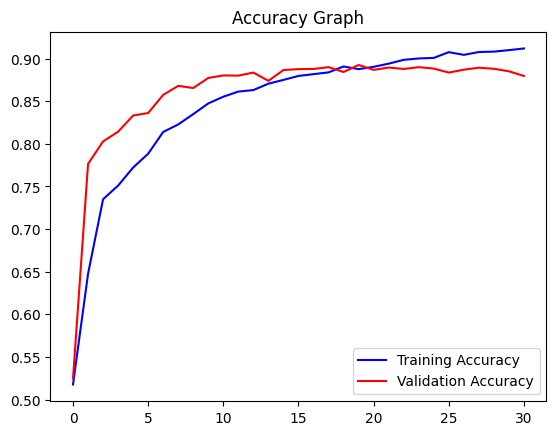

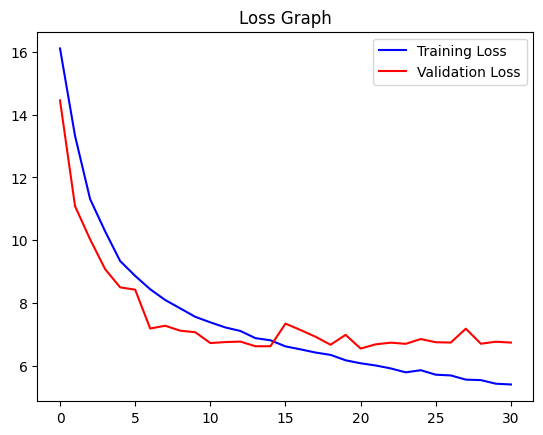

In [22]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [23]:
model_all.save("model_all.h5")

## **Evaluate the Model**

In [24]:
def get_image_features(image):
  img = cv2.imread(image, 0)
  img = Image.fromarray(img)
  img = img.resize((128,128), Image.LANCZOS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

In [25]:
# Load Some images to test with
path_test = '/kaggle/input/utkface-new/crop_part1'
age_labels_test = []
gender_labels_test = []
image_paths_test = []

image_filenames_1 = os.listdir(path_test)
random.shuffle(image_filenames_1)

for image in tqdm(image_filenames_1):
  image_path_test = os.path.join(path_test, image)
  img_components_test = image.split('_')
  age_label_test = int(img_components_test[0])
  gender_label_test = int(img_components_test[1])

  # Append the image_path, age_label, and gender_label
  age_labels_test.append(age_label_test)
  gender_labels_test.append(gender_label_test)
  image_paths_test.append(image_path_test)

  0%|          | 0/9780 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


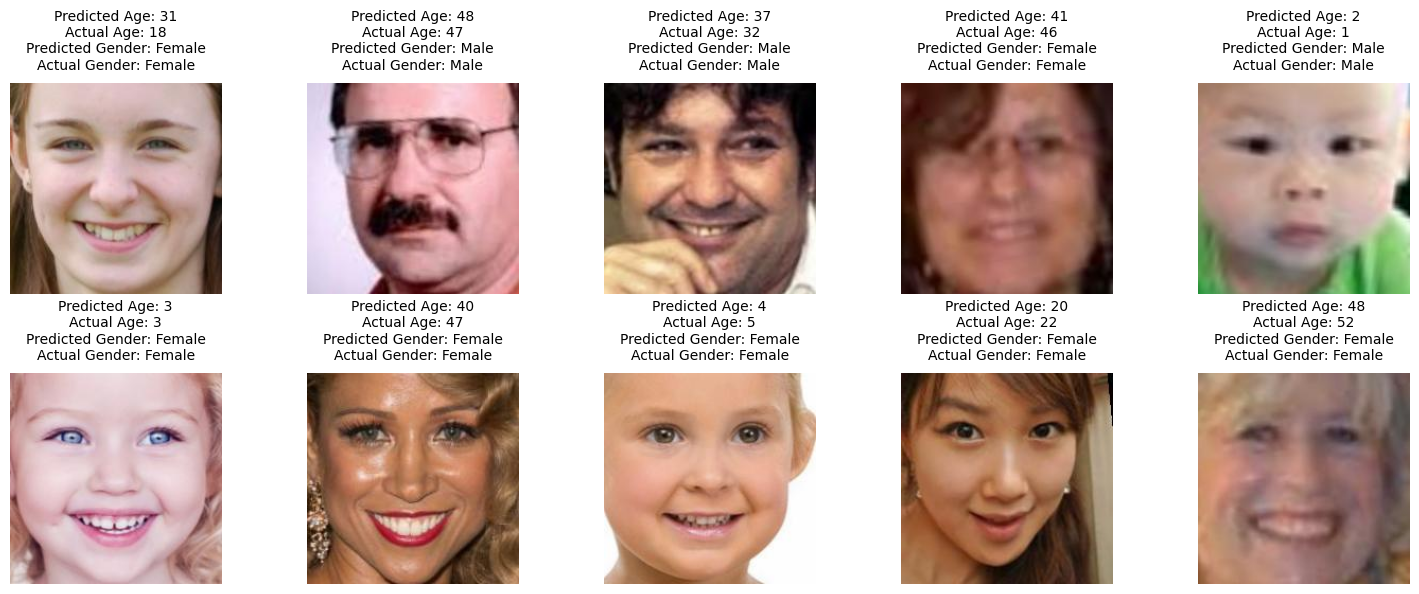

In [26]:
# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Adjust figsize as needed

for i in range(10):
    img_to_test = image_paths_test[i]  # Use the current index 'i' to select a different image
    features = get_image_features(img_to_test)
    pred = model_all.predict(features)

    gender_pred = map_gender_label(round(pred[0][0][0]))
    age_pred = round(pred[1][0][0])
    
    # Load the image
    img = np.array(load_img(img_to_test))
    
    # Display the image in the corresponding subplot
    ax = axes[i // 5, i % 5]  # Calculate the position in the grid
    ax.imshow(img)
    
    # Include actual labels in the title
    ax.set_title(f'Predicted Age: {age_pred}\n'
                 f'Actual Age: {age_labels_test[i]}\n'
                 f'Predicted Gender: {gender_pred}\n'
                 f'Actual Gender: {map_gender_label(gender_labels_test[i])}', 
                 fontsize=10, pad=10)
    
    ax.axis('off')  # Turn off axis

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [27]:
# Lists to store predictions
predicted_genders = []
predicted_ages = []

# Iterate over some test images
for img_to_test in image_paths_test[:3000]:
    features = get_image_features(img_to_test)  # Preprocess the image
    pred = model_all.predict(features, verbose=0)

    # Get predictions
    predicted_genders.append(round(pred[0][0][0]))  # Gender prediction
    predicted_ages.append(round(pred[1][0][0]))      # Age prediction

# Convert lists to numpy arrays for accuracy calculation
predicted_genders = np.array(predicted_genders)
predicted_ages = np.array(predicted_ages)

# Calculate accuracy for gender
gender_accuracy = accuracy_score(gender_labels_test[:3000], predicted_genders)
print(f'Test Gender Accuracy: {gender_accuracy * 100:.2f}%')

# Optionally, if you want to calculate a metric for age predictions:
# For age, you may want to use a different metric (e.g., Mean Absolute Error)
age_mae = mean_squared_error(age_labels_test[:3000], predicted_ages) # MAE for age predictions
age_rmae = np.sqrt(age_mae)
print(f'Mean Absolute Error for Age: {age_mae:.2f}')
print(f'Root Mean Absolute Error for Age: {age_rmae:.2f}')

Test Gender Accuracy: 86.30%
Mean Absolute Error for Age: 47.69
Root Mean Absolute Error for Age: 6.91


In [28]:
report = classification_report(gender_labels_test[:3000], predicted_genders)
print("Classification Report")
print(report)

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1341
           1       0.88      0.88      0.88      1659

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



Confusion Matrix
[[1136  205]
 [ 206 1453]]


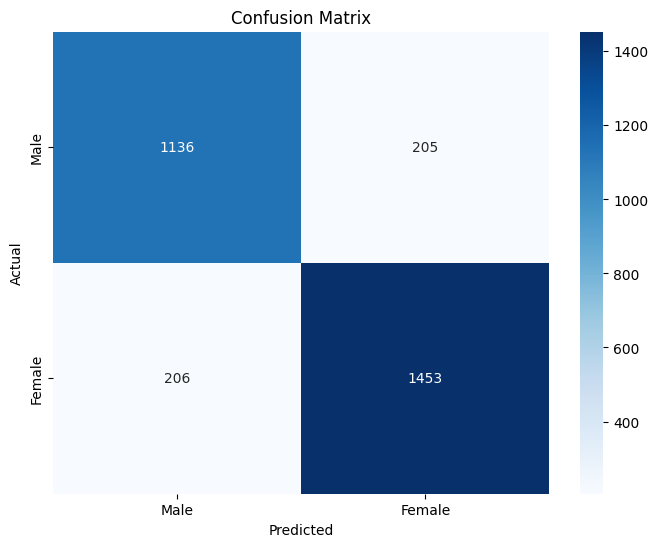

In [30]:
# Confusion matrix
conf_matrix = confusion_matrix(gender_labels_test[:3000], predicted_genders)
print("Confusion Matrix")
print(conf_matrix)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

## **Second Model**

In [31]:
input_shape = (128,128,1)
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
conv_2 = Conv2D(32, kernel_size=(3, 3), activation='relu')(conv_1)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_2)

conv_3 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
conv_4 = Conv2D(64, kernel_size=(3, 3), activation='relu')(conv_3)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_4)


flatten = Flatten()(max_2)

# fully connected layers
dense_1 = Dense(128, activation='relu')(flatten)
dense_2 = Dense(128, activation='relu')(flatten)

dropout_1 = Dropout(0.5)(dense_1)
dropout_2 = Dropout(0.5)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out', kernel_regularizer=l2(0.001))(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out', kernel_regularizer=l2(0.001))(dropout_2)

model_all2 = Model(inputs=[inputs], outputs=[output_1, output_2])

model_all2.compile(
    loss={'gender_out': 'binary_crossentropy', 'age_out': 'mae'}, 
    optimizer='adam', 
    metrics={'gender_out': 'accuracy', 'age_out': 'mae'}
)

In [32]:
model_all2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 126, 126,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 124, 124,  │      9,248 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 62, 62,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 60, 60,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 58, 58,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 29, 29,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 53824)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  6,889,600 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │  6,889,600 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        129 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,844,450 (52.81 MB)

 Trainable params: 13,844,450 (52.81 MB)

 Non-trainable params: 0 (0.00 B)

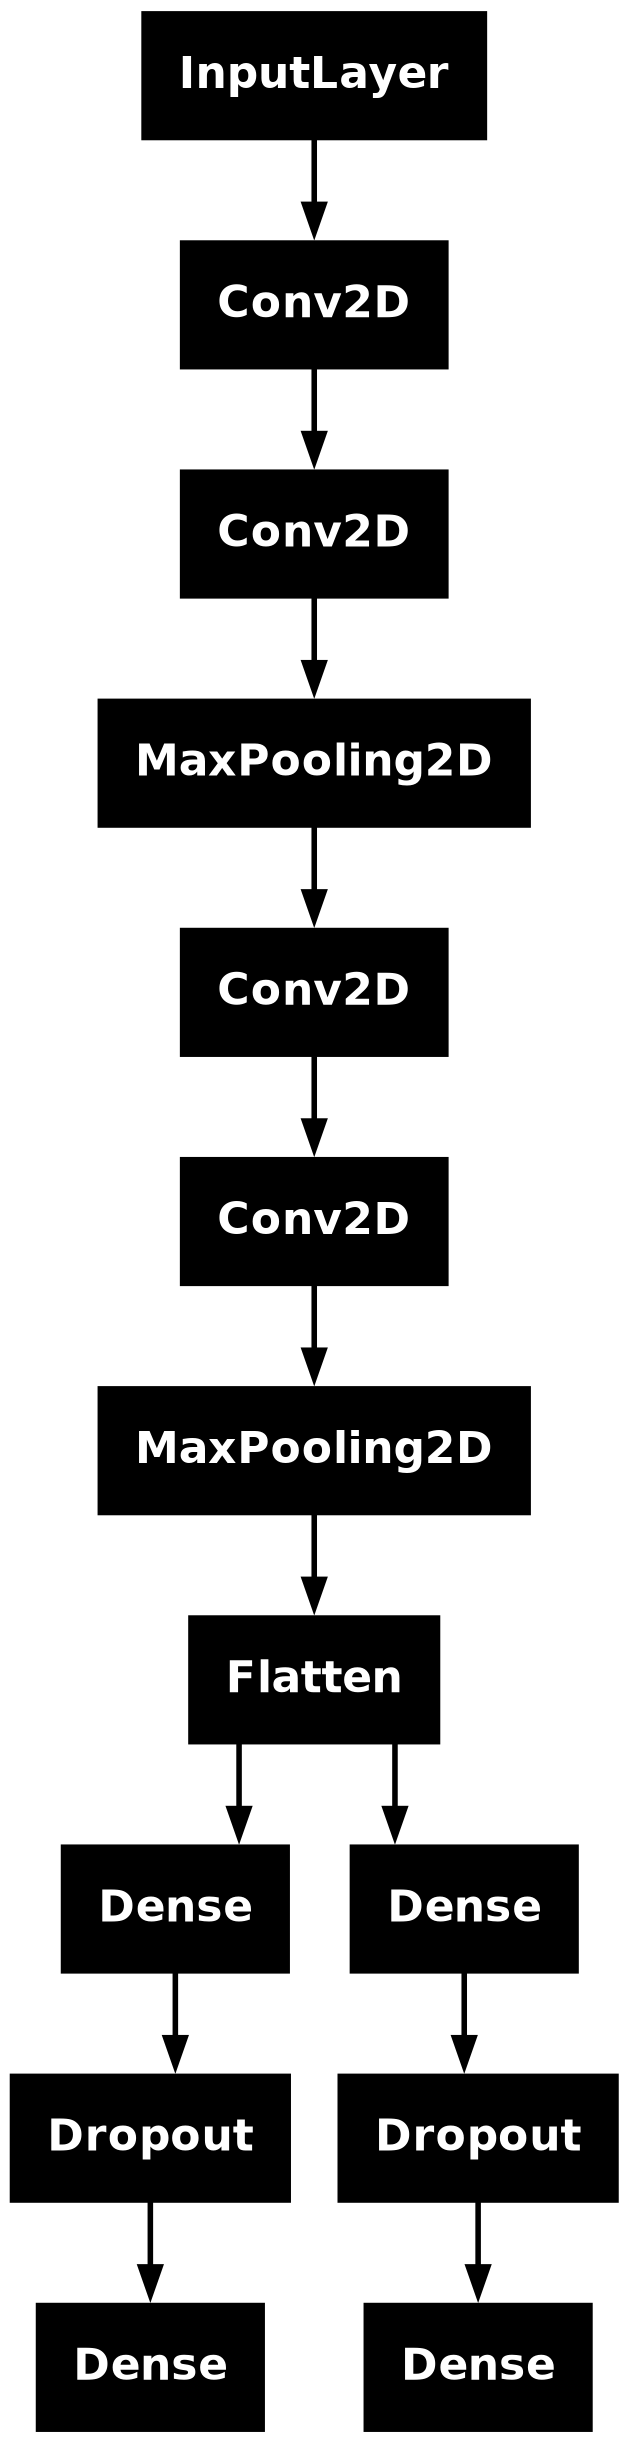

In [33]:
plot_model(model_all2)

In [34]:
history2 = model_all2.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=25, validation_split=0.2)

Epoch 1/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - age_out_mae: 15.5367 - gender_out_accuracy: 0.6194 - loss: 16.2110 - val_age_out_mae: 10.2533 - val_gender_out_accuracy: 0.7995 - val_loss: 10.6661
Epoch 2/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - age_out_mae: 10.3573 - gender_out_accuracy: 0.8196 - loss: 10.7517 - val_age_out_mae: 8.1843 - val_gender_out_accuracy: 0.8606 - val_loss: 8.4772
Epoch 3/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - age_out_mae: 9.1541 - gender_out_accuracy: 0.8500 - loss: 9.4898 - val_age_out_mae: 7.7048 - val_gender_out_accuracy: 0.8730 - val_loss: 7.9721
Epoch 4/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - age_out_mae: 8.5966 - gender_out_accuracy: 0.8729 - loss: 8.8837 - val_age_out_mae: 7.4118 - val_gender_out_accuracy: 0.8813 - val_loss: 7.6708
Epoch 5/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - age_out_mae: 8.0896 - gender_out_accuracy: 0.8851 - loss: 8.3566 - val_age_out_mae: 7.2627 - val_gender_out_accuracy: 0.8798 - val_loss: 7

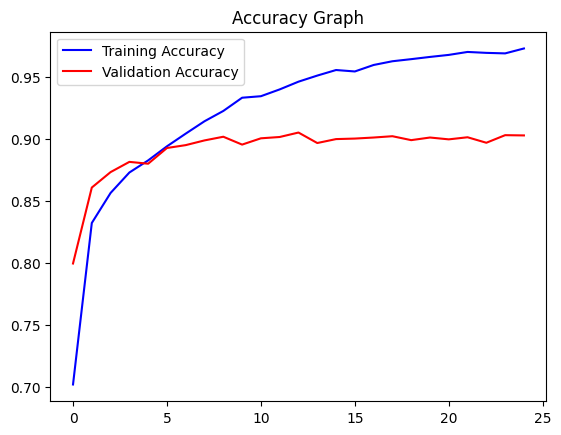

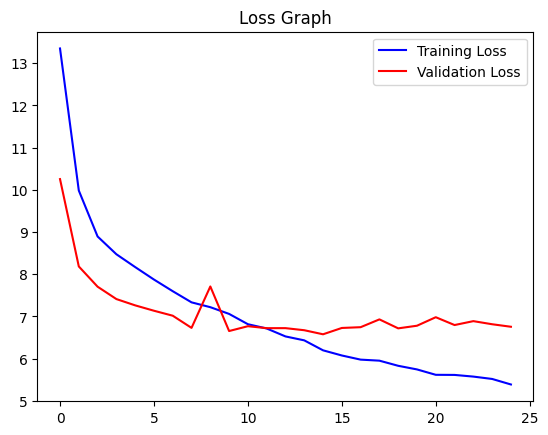

In [35]:
# plot results for gender
acc = history2.history['gender_out_accuracy']
val_acc = history2.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

# plot results for age
loss = history2.history['age_out_mae']
val_loss = history2.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


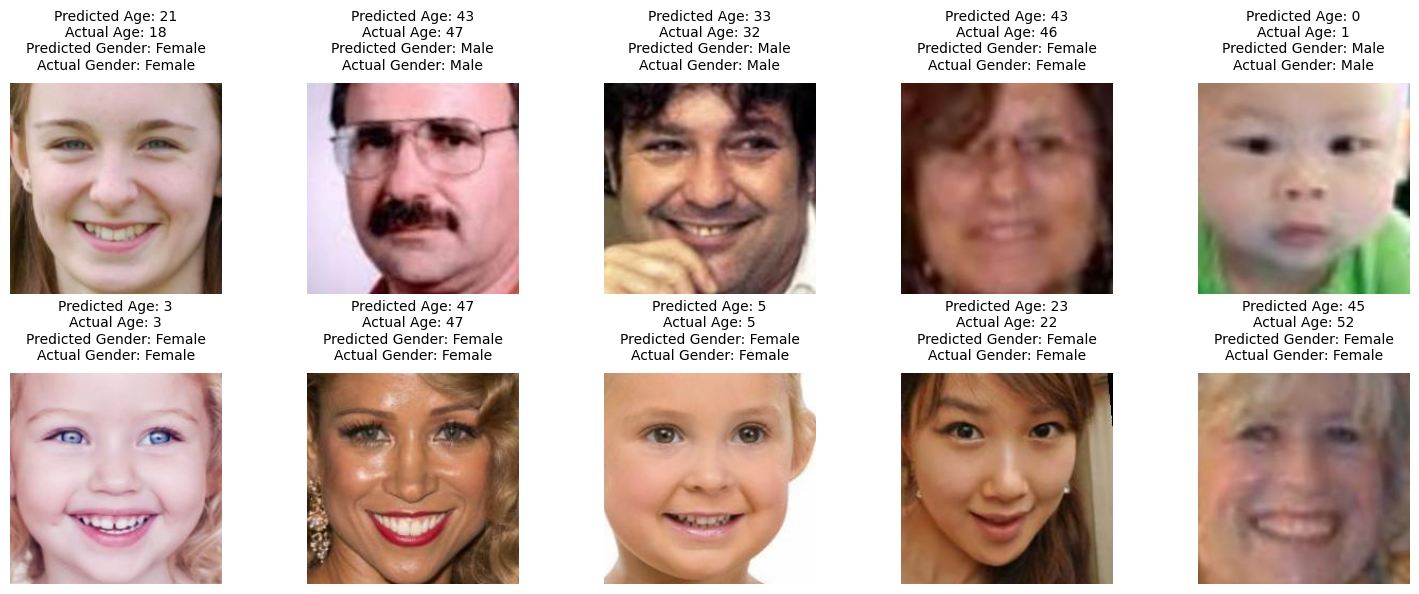

In [36]:
# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Adjust figsize as needed

for i in range(10):
    img_to_test = image_paths_test[i]  # Use the current index 'i' to select a different image
    features = get_image_features(img_to_test)
    pred = model_all2.predict(features)

    gender_pred = map_gender_label(round(pred[0][0][0]))
    age_pred = round(pred[1][0][0])
    
    # Load the image
    img = np.array(load_img(img_to_test))
    
    # Display the image in the corresponding subplot
    ax = axes[i // 5, i % 5]  # Calculate the position in the grid
    ax.imshow(img)
    
    # Include actual labels in the title
    ax.set_title(f'Predicted Age: {age_pred}\n'
                 f'Actual Age: {age_labels_test[i]}\n'
                 f'Predicted Gender: {gender_pred}\n'
                 f'Actual Gender: {map_gender_label(gender_labels_test[i])}', 
                 fontsize=10, pad=10)
    
    ax.axis('off')  # Turn off axis

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [40]:
# Lists to store predictions
predicted_genders = []
predicted_ages = []

# Iterate over some test images
for img_to_test in image_paths_test[3000:6000]:
    features = get_image_features(img_to_test)  # Preprocess the image
    pred = model_all2.predict(features, verbose=0)

    # Get predictions
    predicted_genders.append(round(pred[0][0][0]))  # Gender prediction
    predicted_ages.append(round(pred[1][0][0]))      # Age prediction

# Convert lists to numpy arrays for accuracy calculation
predicted_genders = np.array(predicted_genders)
predicted_ages = np.array(predicted_ages)

# Calculate accuracy for gender
gender_accuracy = accuracy_score(gender_labels_test[3000:6000], predicted_genders)
print(f'Test Gender Accuracy: {gender_accuracy * 100:.2f}%')

# Optionally, if you want to calculate a metric for age predictions:
# For age, you may want to use a different metric (e.g., Mean Absolute Error)
age_mae = mean_squared_error(age_labels_test[3000:6000], predicted_ages) # MAE for age predictions
age_rmae = np.sqrt(age_mae)
print(f'Mean Absolute Error for Age: {age_mae:.2f}')
print(f'Root Mean Absolute Error for Age: {age_rmae:.2f}')

Test Gender Accuracy: 96.40%
Mean Absolute Error for Age: 34.92
Root Mean Absolute Error for Age: 5.91


In [41]:
report = classification_report(gender_labels_test[3000:6000], predicted_genders)
print("Classification Report")
print(report)

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1360
           1       0.96      0.97      0.97      1639
           3       0.00      0.00      0.00         1

    accuracy                           0.96      3000
   macro avg       0.64      0.64      0.64      3000
weighted avg       0.96      0.96      0.96      3000



Confusion Matrix
[[1301   59    0]
 [  48 1591    0]
 [   0    1    0]]


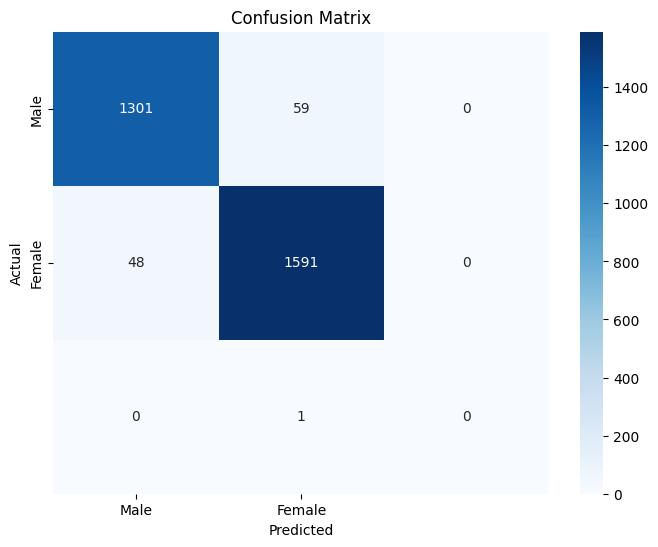

In [42]:
# Confusion matrix
conf_matrix = confusion_matrix(gender_labels_test[3000:6000], predicted_genders)
print("Confusion Matrix")
print(conf_matrix)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [43]:
model_all2.save("model_all2.h5")